(sec:mp2)=
# Møller–Plesset

## Møller–Plesset partitioning

When using [perturbation theory](pt), a very common partitioning of the Hamiltonian is the using the Møller–Plesset (MP) {cite}`Szabo2012,Helgaker2014,mbpt2009` scheme, which follows quite naturally when first approximating the desired ground state in terms of a single reference determinant. The Hamiltonian is rewritten as

\begin{equation*}
\hat{H} = \hat{F} + \hat{\Phi}
\end{equation*}

where $\hat{F}$ is the Fock operator and $\hat{\Phi}$ is the so-called fluctuation potential, which is a two-body operator.

$\hat{F}$ is a one-body operator whose spectrum consists of all determinants that can be built from excitation of the reference $| 0 \rangle$

\begin{align*}
\hat{F} | 0 \rangle  &= E_{0}^{(0)}| 0 \rangle \\
\hat{F} \left|_{ij\ldots} ^{ab\ldots} \right\rangle &=
\left(E_{0}^{(0)} + \varepsilon^{ab\cdots}_{ij\cdots}  \right)
\left|_{ij\ldots} ^{ab\ldots} \right\rangle
\end{align*}

The zeroth-order energy and the orbital-energy denominators are

\begin{align*}
E_{0}^{(0)} &= \sum_{i} \varepsilon_{i} \\
\varepsilon^{ab\cdots}_{ij\cdots} &= \varepsilon_{a} + \varepsilon_{b} + \ldots - \varepsilon_{i} - \varepsilon_{j} - \ldots
\end{align*}

With $i,j,\ldots$ referring to occupied orbitals, whereas $a,b,\ldots$ refer to unoccupied (virtual) ones.

Using this partitioning, the zeroth-order energy is the sum of orbital energies, and the first-order correction is

\begin{equation*}
E_0^{(1)} = \left\langle 0 \left| \hat{\Phi} \right| 0 \right\rangle = -\frac{1}{2} \sum_{ij} \langle ij \| ij \rangle
\end{equation*}

that is, the energy of the reference single determinant is correct through first order in the perturbative series

$$
E_{\mathrm{ref}} = E_{\mathrm{HF}} = E_{0}^{(0)} + E_0^{(1)}
$$

(label:mp1-wf)=
The first-order correction to the wave function is obtained from the [RSPT master equation](pt). In a basis of molecular spin-orbitals, it is given by

\begin{equation*}
| \Psi_0^{(1)} \rangle = -\frac{1}{4}\sum_{ijab}  
\frac{\langle ab \| ij \rangle}{\varepsilon_{ij}^{ab}} |_{ij}^{ab}\rangle \
\end{equation*}

The expansion coefficients are identified as the so-called $t$-amplitudes

\begin{equation*}
t_{ijab} = \frac{\langle ab \| ij \rangle}{\varepsilon_{ij}^{ab}} \, 
\end{equation*}

(eq:mp2-energy)=
The second-order energy correction is

\begin{equation*}
E_{0}^{(2)}  = - \frac{1}{4} 
\sum_{ijab} \frac{\langle ij \| ab \rangle \langle ab \| ij \rangle}{\varepsilon_{ij}^{ab}}
= - \frac{1}{4} \sum_{ijab} t_{ijab} \langle ij || ab \rangle
\end{equation*}

and the total MP2 energy is given by $E_{\mathrm{MP2}} = E_{\mathrm{HF}} + E_0^{(2)}$.
For a closed-shell, restricted reference using real MOs, $E_0^{(2)}$ can be written as

\begin{equation*}
E_0^{(2)} = -
\sum_{ij}^{N_{\mathrm{O}}} \sum_{ab}^{N_{\mathrm{V}}} 
\frac{\langle ij | ab \rangle}{\varepsilon_{ij}^{ab}}
[ 2 \langle ij | ab \rangle - \langle ij | ba \rangle ]
\end{equation*}

where $N_{\mathrm{O}}$ is the number of occupied spatial orbitals ($N/2$), and $N_{\mathrm{V}}$ the number of virtual spatial orbitals. This can be further rearrange into two terms called opposite-spin (OS) and same-spin (SS)

\begin{equation*}
E_0^{(2)} = -
\sum_{ij}^{N_{\mathrm{O}}} \sum_{ab}^{N_{\mathrm{V}}} 
\frac{\langle ij | ab \rangle\langle ij | ab \rangle}{\varepsilon_{ij}^{ab}} -
\sum_{ij}^{N_{\mathrm{O}}} \sum_{ab}^{N_{\mathrm{V}}} 
\frac{\langle ij | ab \rangle[ \langle ij | ab \rangle - \langle ij | ba \rangle ]}{\varepsilon_{ij}^{ab}} = 
E_{\mathrm{OS}}^{(2)} + E_{\mathrm{SS}}^{(2)}.
\end{equation*}

## Implementation

To compute $E_0^{(2)}$ we need to:

1. obtain the reference closed-shell determinant from a Hartree--Fock calculation
2. transform the AO basis ERI tensor to MO basis
3. assemble the energy denominators
4. combine the results of steps 2 and 3 to form the perturbative correction

![Obtaining the MP2 energy correction](../../img/misc/mp2.svg)

### Obtaining the HF reference

In [1]:
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 10.


In [2]:
h2o_xyz = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(molecule, "cc-pvdz", ostream=None)

molecule.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [3]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(molecule, basis)

We can now access orbital energies and MO coefficients from the SCF driver

In [4]:
E = scf_results["E"]
C = scf_results["C"]

### Transforming the integrals

We compute the MP2 energy correction with the ERI expressed in MO basis, and thus need to transform the ERI tensor from AO basis. The transformation reads

\begin{equation*}
\langle pq | rs \rangle = \sum_{\mu\nu\kappa\lambda} C_{\mu p}C_{\nu r} (\mu\nu|\kappa\lambda) C_{\kappa q} C_{\lambda s}
\end{equation*}

with the MO integrals in [**physicists' notation**](http://vergil.chemistry.gatech.edu/notes/permsymm/permsymm.html). The transformation requires $O(N^{8})$ operation count. However, we can perform it more efficiently as a step-wise contraction:

\begin{equation*}
\langle pq | rs \rangle = \sum_{\mu} C_{\mu p}  \left(\sum_{\nu} C_{\nu r}  \left (\sum_{\kappa} \left(\sum_{\lambda} (\mu\nu|\kappa\lambda) C_{\lambda s} \right) C_{\kappa q} \right)\right)
\end{equation*}

Note that we do **not** need the full ERI tensor in MO basis, but rather the *OOVV* class of integrals, which involve two occupied and two virtual MO indices

\begin{equation*}
\langle ij | ab \rangle = 
\sum_{\mu} C_{\mu i}  
\left(\sum_{\nu} C_{\nu j}  
\left(\sum_{\kappa} 
\left(\sum_{\lambda} (\mu\kappa|\nu\lambda) C_{\lambda b} \right)
C_{\kappa a}\right)\right)
\end{equation*}

In [5]:
eridrv = vlx.ElectronRepulsionIntegralsDriver()
mknl = eridrv.compute_in_memory(molecule, basis)

In [6]:
import numpy as np

N_O = molecule.number_of_alpha_electrons()
N_V = scf_drv.mol_orbs.number_mos() - N_O

mknb = np.einsum("mknl,lB->mknB", mknl, C[:, N_O:])
print(f"mknb.shape={mknb.shape}")
mnab = np.einsum("mknB,kA->mnAB", mknb, C[:, N_O:])
print(f"mnab.shape={mnab.shape}")
mjab = np.einsum("mnAB,nJ->mJAB", mnab, C[:, :N_O])
print(f"mjab.shape={mjab.shape}")
ijab = np.einsum("mJAB,mI->IJAB", mjab, C[:, :N_O])
print(f"ijab.shape={ijab.shape}")

mknb.shape=(24, 24, 24, 19)
mnab.shape=(24, 24, 19, 19)
mjab.shape=(24, 5, 19, 19)
ijab.shape=(5, 5, 19, 19)


Compare our *OOVV* ERI tensor with the one computed by using `MOIntegralsDriver`:

In [7]:
moeridrv = vlx.MOIntegralsDriver()
moeri = moeridrv.compute_in_memory(
    molecule, basis, mol_orbs=scf_drv.mol_orbs, moints_name="phys_OOVV"
)

np.testing.assert_allclose(ijab, moeri, atol=1.0e-10)

### The MP2 energy correction

We now have all the ingredients to compute the opposite-spin and same-spin components of the MP2 energy correction

In [8]:
e_mp2_ss = 0.0
e_mp2_os = 0.0

# extract the occupied subset of the orbital energies
e_ij = E[:N_O]
# extract the virtual subset of the orbital energies
e_ab = E[N_O:]

for i in range(N_O):
    for j in range(N_O):
        for a in range(N_V):
            for b in range(N_V):
                # enegy denominators
                e_ijab = e_ab[a] + e_ab[b] - e_ij[i] - e_ij[j]

                # update opposite-spin component of the energy
                e_mp2_os -= (ijab[i, j, a, b] * ijab[i, j, a, b]) / e_ijab

                # update same-spin component of the energy
                e_mp2_ss -= (
                    ijab[i, j, a, b] * (ijab[i, j, a, b] - ijab[i, j, b, a]) / e_ijab
                )

In [9]:
print(f"Opposite-spin MP2 energy: {e_mp2_os:9.7f}")
print(f"Same-spin MP2 energy:     {e_mp2_ss:9.7f}")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:9.7f}")

Opposite-spin MP2 energy: -0.1516308
Same-spin MP2 energy:     -0.0513819
MP2 energy:               -0.2030127


Comparing to MP2 implementation in VeloxChem:

In [10]:
mp2_drv = vlx.Mp2Driver()
mp2_drv.ostream.mute()

mp2_results = mp2_drv.compute_conventional(molecule, basis, scf_drv.mol_orbs)

In [11]:
print(f"Energy difference: {e_mp2_os + e_mp2_ss - mp2_results['mp2_energy']:8.2E}")

Energy difference: 1.11E-16


(sec:mp2-size-consistency)=
## Size consistency

We see that to second order, Møller-Plesset perturbation theory only involves up to double excitations from the HF reference. It would thus be natural to consider it an approximation to CISD, and expect it to suffer from the same issue, namely a lack of size consistency. Yet this is not the case:

In [12]:
dimer_xyz = """6
2 water 100 Å apart                                                                                                            
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
O  100.000000000000        0.000000000000        0.000000000000                         
H  100.000000000000        0.740848095288        0.582094932012                         
H  100.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(dimer_xyz)
basis = vlx.MolecularBasis.read(molecule, "cc-pvdz", ostream=None)

In [13]:
molecule.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(molecule, basis)

In [15]:
mp2_dimer_results = mp2_drv.compute_conventional(molecule, basis, scf_drv.mol_orbs)

In [16]:
print("=" * 30)
print("MP2 energies")
print("-" * 30)
print(f"Dimer       : {mp2_dimer_results['mp2_energy']:16.10f}")
print(f"Two monomers: {2 * mp2_results['mp2_energy']:16.10f}")
print("=" * 30)

MP2 energies
------------------------------
Dimer       :    -0.4060254140
Two monomers:    -0.4060254051


We can see that the two energies match. MP2 is size consistent! So why is it behaving better than CISD in this aspect?

The key is that in MP2, the coefficients of the excited determinants are independent of the system size. Thus a molecule would have the same MP2 energy correction regardless of the presence or not of another, non-interacting, molecule. By contrast, in CISD, the coefficients depend on the system size through normalization, lowering the weight of these determinants as the size of the system increases.

(sec:mp2-taylor)=
## Taylor expansion of the energy

In using [Rayleigh--Schrödinger perturbation theory](pt) (RSPT), it is a common practice to use an expansion in the perturbation strength $\lambda$, with $\hat{H} = \hat{H_0} + \lambda \hat{V}$. Each order of perturbation then corresponds to a power of $\lambda$

$$
E = E^{0} + \lambda E^{1} + \lambda^2 E^{2} + ...
$$

The RSPT equations are then simply found by collecting together equal powers of $\lambda$ and at the end, $\lambda$ is set to 1.0 to recover the standard Hamiltonian. With this framework, it is easy to see how RSPT is related to Taylor expansions. In this section, we will make this link more explicit.

Let's explicitly create these Hamiltonian and compute the exact energy for different values of $\lambda$ using the CI driver. First let us recompute the energy with a minimal basis.

In [17]:
molecule = vlx.Molecule.read_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(molecule, "sto-3g", ostream=None)

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(molecule, basis)

E = scf_results["E"]
C = scf_results["C"]

Now let's create $\hat{H_0} = \hat{F}$ and $\hat{V}$ in molecular orbital basis. $\hat{F}$ is a one-electron Hamiltonian while for $\hat{V}$ we need both the one and two-electron components.

In [18]:
F = scf_results["F"][0]  # Fock matrix from SCF
F_MO = np.matmul(np.matmul(C.T, F), C)

# Get the 1-electron integrals
kin_drv = vlx.KineticEnergyIntegralsDriver()
T_ao = kin_drv.compute(molecule, basis).to_numpy()
npot_drv = vlx.NuclearPotentialIntegralsDriver()
V_ao = -npot_drv.compute(molecule, basis).to_numpy()

# core Hamiltonian
h_MO = np.einsum("ai, ab, bj -> ij", C, T_ao + V_ao, C)

# Compute the 2-electron integrals
naos = V_ao.shape[0]
eridrv = vlx.ElectronRepulsionIntegralsDriver()
mknl = np.zeros((naos, naos, naos, naos))
eridrv.compute_in_memory(molecule, basis, mknl)

# Transform them to the (full) MO basis
mknb = np.einsum("mknl,lB->mknB", mknl, C)
mnab = np.einsum("mknB,nA->mkAB", mknb, C)
mjab = np.einsum("mkAB,kJ->mJAB", mnab, C)
ijab = np.einsum("mJAB,mI->IJAB", mjab, C)

H0_1 = F_MO
V_1 = h_MO - F_MO
V_2 = ijab

Solving the CI for increasing values of $\lambda$:

In [19]:
import multipsi as mtp

npoints = 21

ci_drv = mtp.CIDriver()
ci_drv.ostream.mute()

space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.fci()

energies = []
for i in range(npoints):
    lambda_val = i / (npoints - 1)
    ci_drv._update_integrals(
        molecule.nuclear_repulsion_energy(), H0_1 + lambda_val * V_1, lambda_val * V_2
    )
    ci_results = ci_drv.compute(molecule, basis, space, 1)
    energies.append(ci_drv.get_energy())

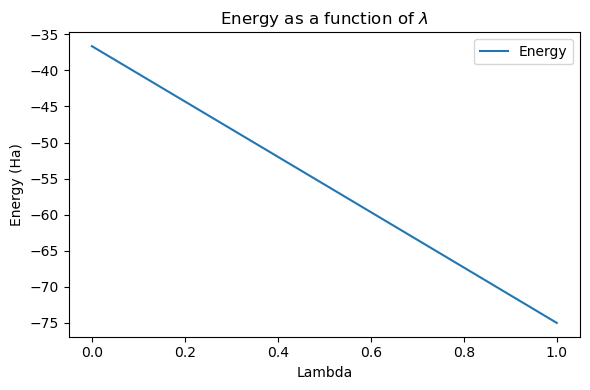

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.title("Energy as a function of $\lambda$")
x = np.array(range(npoints)) / (npoints - 1)
y = np.array(energies)
plt.plot(x, y, label="Energy")

plt.xlabel("Lambda")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.tight_layout()
plt.show()

Before going further, we notice that the energy does not start at the HF energy (-74.96033 Ha) but a much higher one. This is because the Fock Hamiltonian gives not the HF energy but twice the sum of orbital energies (+ the nuclear repulsion).

In [21]:
N = molecule.number_of_alpha_electrons()
print(
    f"Sum of orbital energies : {2*np.sum(E[:N]) + molecule.nuclear_repulsion_energy():9.6f}"
)
print(f"Energy for lambda = 0   : {energies[0]:9.6f}")

Sum of orbital energies : -36.642187
Energy for lambda = 0   : -36.642186


With this parenthesis being closed, the concept of RSPT in this Taylor framework is to find the best approximation of the energy at $\lambda = 1$ (which is our exact full CI energy) using only quantities that are available in the easier $\lambda = 0$ Hamiltonian. For this we try to fit the curve above with a Taylor expansion at $\lambda = 0$. We immediately notice that the curve looks almost like a straight line, implying that we may get already a good approximation with just the gradient.

For demonstration purpose, let us compute these gradients numerically by fitting the curve above for very small values of $\lambda = 0$.

In [22]:
increment = 0.001
small_energies = []
for i in range(3):
    lambda_val = i * increment
    ci_drv._update_integrals(
        molecule.nuclear_repulsion_energy(), H0_1 + lambda_val * V_1, lambda_val * V_2
    )
    ci_results = ci_drv.compute(molecule, basis, space, 1)
    small_energies.append(ci_drv.get_energy())

In [23]:
# Compute first derivative from the first point
First_deriv = (small_energies[1] - small_energies[0]) / increment
print(f"SCF energy       : {scf_drv.get_scf_energy():9.6f}")
print(f"0th order energy : {small_energies[0]:9.6f}")
print(f"1st order energy : {small_energies[0] + First_deriv:9.6f}")

SCF energy       : -74.960337
0th order energy : -36.642186
1st order energy : -74.960371


We see that the first derivative is actually the difference between the HF energy and the sum of orbital energies. Thus when extrapolating to $\lambda = 1$, we get back the HF energy (apart for numerical errors). This fits exactly what we had found above, namely that the Hartree-Fock energy is the sum of the zeroth and first order MP energies.

Let's now see the difference between the previously computed energy and the first order approximation of it to properly visualize the contributions from higher order (and thus the correlation energy). Then let's fit the 3 points we got for small values of $\lambda$ to a second order polynomial.

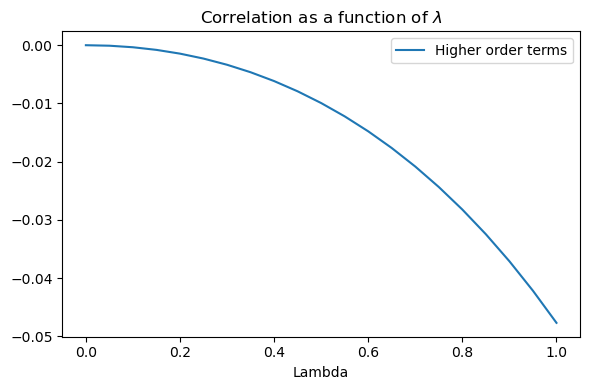

In [24]:
plt.figure(figsize=(6, 4))
plt.title("Correlation as a function of $\lambda$")
x = np.array(range(npoints)) / (npoints - 1)
y = np.array(energies) - (energies[0] + x * First_deriv)
plt.plot(x, y, label="Higher order terms")
plt.xlabel("Lambda")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
coefs = np.polyfit(np.array([0, increment, 2 * increment]), np.array(small_energies), 2)
E0 = coefs[2]
E1 = coefs[1]
E2 = coefs[0]

print(f"0th order term : {E0:9.6f}")
print(f"linear term    : {E1:9.6f}")
print(f"0th + 1st order: {E0 + E1:9.6f}")
print(f"quadratic term :  {E2:9.6f}")

0th order term : -36.642186
linear term    : -38.318151
0th + 1st order: -74.960337
quadratic term :  -0.034393


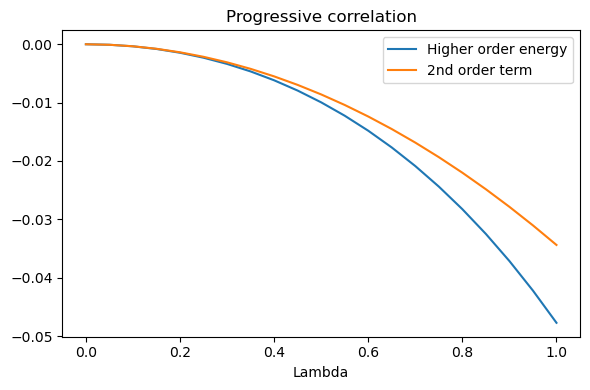

In [33]:
plt.figure(figsize=(6, 4))

x = np.array(range(npoints)) / (npoints - 1)
y = np.array(energies) - (E0 + x * E1)
z = E2 * x**2

plt.plot(x, y, label="Higher order energy")
plt.plot(x, z, label="2nd order term")

plt.title("Progressive correlation")
plt.xlabel("Lambda")

plt.legend()

plt.tight_layout()

plt.show()

With the second order term, we recover a decent fraction of the missing energy (i.e. of the correlation energy). Note that this what we printed here is the coefficient in front of the quadratic term, not the second derivative, the two differ by a factor of 2. However, this term can be directly compared to the MP2 energy and we see that they indeed match:

In [27]:
mp2_results = mp2_drv.compute(molecule, basis, scf_drv.mol_orbs)

In [28]:
print(f"MP2 energy    :{mp2_results['mp2_energy']:10.6f}")
print(f"Quadratic term:{E2:10.6f}")

MP2 energy    : -0.034401
Quadratic term: -0.034393


With this little exercise, we have clearly illustrated how the MP expansion is simply a Taylor expansion of the fullCI energy for $\lambda = 0$. In other words, it is an attempt to recover as much as possible from the energy of the true Hamiltonian by using a Taylor expansion of the energy at a much simpler Hamiltonian.